In [1]:
import pandas as pd
import driver
import googlemaps

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import config

Choose our destination and grab information.

In [2]:
df = driver.google_search('Cancun')

In [3]:
df

,Attractions,Descriptions,City,Ratings,Reviews,Genres
0,Isla Mujeres,Playa Norte beach & sea turtle sanctuary,Cancun,4.7,"(2,122)",Outdoors
1,Xcaret Park,Eco-archaeological park with attractions,Cancun,4.8,"(60,994)",Outdoors
2,Xel-Há Park,Natural aquarium with many activities,Cancun,4.8,"(24,714)",Outdoors
3,Cancún Underwater Museum,Contemporary underwater sculpture museum,Cancun,4.5,(383),Outdoors
4,Dos Ojos Cenote,Natural caves & scenic swimming holes,Cancun,4.7,"(2,357)",Outdoors
...,...,...,...,...,...,...
145,Cancun Country Club,Golf and country club,Cancun,4.5,(293),Kid-friendly
146,Amigos de Isla Contoy,Island,Cancun,5.0,(1),Kid-friendly
147,Holy Family Parish Cancun,Catholic church,Cancun,4.7,(575),Kid-friendly
148,Marlín Beach,Beach,Cancun,4.6,(89),Kid-friendly


Join genres together as an attraction may fall under multiple genres

In [5]:
test = df.groupby("Attractions")['Genres'].apply(lambda genres_cats: '|'.join(genres_cats)).to_frame()
del df['Genres']
df = df.drop_duplicates()

df = pd.merge(test,df, how = "left", on = 'Attractions')
df = df.drop_duplicates(subset = 'Attractions', keep = 'first').reset_index(drop = True)

From above, we see that in the 'Reviews' column, there are parentheses. Let's perform regex and remove them so that they are more readable.

In [7]:
# Convert using map and lambda if possible
import re 

clear_lst = []

for i in range(len(df)):
    if df.Reviews[i] == 'N/A':
        clear_lst.append('N/A')
    else:
        result = re.search(r'\((.*?)\)',df['Reviews'][i]).group(1)
        clear_lst.append(result)
        
df.Reviews = clear_lst

In [8]:
df.head()

,Attractions,Genres,Descriptions,City,Ratings,Reviews
0,AQUARIUS Los Delfines,Museums,Aquarium,Cancun,4.5,88
1,Amigos de Isla Contoy,Kid-friendly,Island,Cancun,5.0,1
2,Aquaworld,Outdoors,"Snorkeling, fishing, scuba diving, parasailing...",Cancun,4.1,672
3,Artesano Park,Kid-friendly,Park,Cancun,4.3,600
4,Bungee in Cancun,Outdoors,Bungee jumping,Cancun,4.6,38


## Geocoding: get the coordinates of each location

In [9]:
list_of_lat, list_of_lon, list_of_addr  = [], [], []

gmaps = googlemaps.Client(key=config.api_key) 

def geocode_address(attraction, city):
    try:
        query = attraction + city
        geocode_result = gmaps.geocode(query)
        
        geom = geocode_result[0]
        lat = geom["geometry"]["location"]["lat"]
        lon = geom["geometry"]["location"]["lng"]
        addr = geom['formatted_address']

        list_of_lat.append(lat)
        list_of_lon.append(lon)
        list_of_addr.append(addr)
    
    except:
        list_of_lat.append('NA')
        list_of_lon.append('NA')
        list_of_addr.append('NA')

for attraction, city in zip(df.Attractions, df.City):
    geocode_address(attraction,city)

In [10]:
df['Latitude'] = list_of_lat
df['Longitude'] = list_of_lon
df['Address'] = list_of_addr

In [11]:
df.head()

,Attractions,Genres,Descriptions,City,Ratings,Reviews,Latitude,Longitude,Address
0,AQUARIUS Los Delfines,Museums,Aquarium,Cancun,4.5,88,21.1402,-86.8683,"MZA 46 Lte 13, Av. Nichupté 96, 96, 77535 Canc..."
1,Amigos de Isla Contoy,Kid-friendly,Island,Cancun,5.0,1,21.1625,-86.834,"28, 77509 Cancún, Quintana Roo, Mexico"
2,Aquaworld,Outdoors,"Snorkeling, fishing, scuba diving, parasailing...",Cancun,4.1,672,21.0841,-86.7748,"Blvd. Kukulcan, Zona Hotelera, 77500 Cancún, Q..."
3,Artesano Park,Kid-friendly,Park,Cancun,4.3,600,21.1626,-86.8271,"Artesano Park, MZA 26, Margaritas 26, 22, 7750..."
4,Bungee in Cancun,Outdoors,Bungee jumping,Cancun,4.6,38,21.1394,-86.769,"Km 6.5 Marina Adventure Bay Playa Tortugas, Bl..."


Remove the locations where is NA

In [14]:
df = df[df.Latitude != 'NA']

# Sampling
Let's try to pick a couple random choices 

In [15]:
sample_df = df.sample(n = 20)
sample_df.Attractions

10                             Cancún Underwater Museum
87                                          Tortugranja
34                                               Ik Kil
77                                          Punta Molas
95                       Yamil Lu'um Archeological Site
83                                  Scenic Tower Cancun
90                                               Xcacel
56                         Planetario De Cancún Ka´Yok´
60                                       Playa Chacmool
73                                            Playa Sol
12                                        Caracol Beach
94                                            Xoximilco
7                                   Cancun Country Club
30                                    Fragata Catamaran
49                  Parador Fotográfico •Letras Cancún•
92                                          Xel-Há Park
63                                       Playa El Cocal
19                       Columbus Lobster Dinner

In [16]:
sample_df = sample_df.reset_index(drop = True)

Round the decimals to 4 digits for Latitude and Longitude

In [17]:
sample_df['Latitude'] = sample_df['Latitude'].apply(lambda x: round(x, 4))
sample_df['Longitude'] = sample_df['Longitude'].apply(lambda x: round(x, 4))

Let's first plot the locations and see their locations

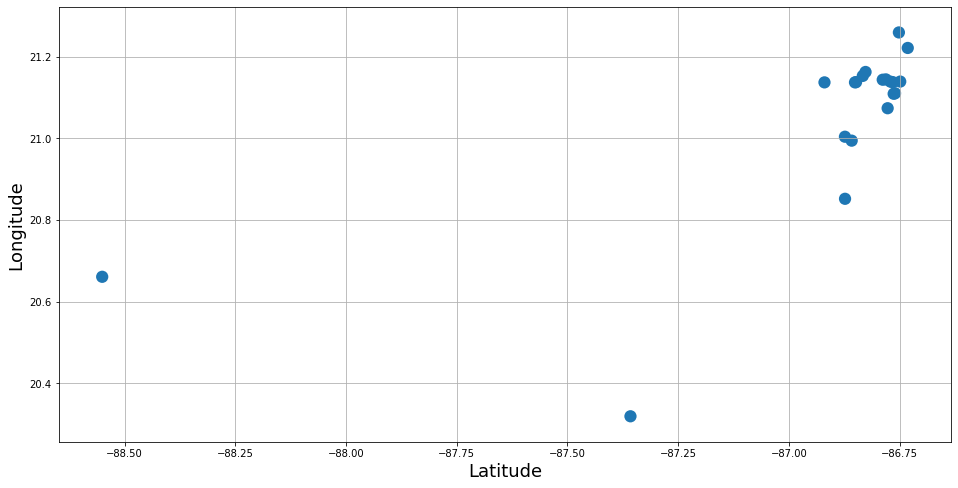

In [18]:
fig = plt.figure(figsize=(16,8))
cmap = plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(sample_df['Longitude'], sample_df['Latitude'],
            cmap=cmap, norm=norm, s=150, edgecolor='none')
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.grid()
plt.show()

In [53]:
# Sample such that based on genres
# How many attractions do you hope to visit?
# 
#Grab DataFrame rows where column has certain values
#df[df.name.isin(value_list)]
df[df.Genres.isin(['Kid-friendly'])]

,Attractions,Genres,Descriptions,City,Ratings,Reviews,Latitude,Longitude,Address
1,Amigos de Isla Contoy,Kid-friendly,Island,Cancun,5.0,1,21.1625,-86.834,"28, 77509 Cancún, Quintana Roo, Mexico"
3,Artesano Park,Kid-friendly,Park,Cancun,4.3,600,21.1626,-86.8271,"Artesano Park, MZA 26, Margaritas 26, 22, 7750..."
6,CANCUN GOLF COURSE THE TINTO,Kid-friendly,Golf and country club,Cancun,4.5,121,21.005,-86.8729,"Carr. Federal 307, Chetumal Km 388, 77580 Canc..."
7,Cancun Country Club,Kid-friendly,Golf and country club,Cancun,4.5,293,21.004,-86.8736,"Km. 388, México 307, 46, 77580 Cancún, Q.R., M..."
8,Cancun Golf Club at Pok ta Pok,Kid-friendly,Golf,Cancun,4.2,252,21.1315,-86.7608,"Blvd. Kukulcan Km. 7.5, Punta Cancun, Zona Hot..."
11,Captain Hook / Puente Calinda,Kid-friendly,Fishing,Cancun,4.6,298,21.1435,-86.788,"Captain Hook / Puente Calinda, Blvd. Kukulcan,..."
19,Columbus Lobster Dinner Cruise,Kid-friendly,Dinner cruise on an old-fashioned ship,Cancun,4.7,258,21.1388,-86.7706,"Blvd. Kukulcan Km 6.5, Kukulcan Boulevard, Zon..."
24,Dolphin Discovery Isla Mujeres,Kid-friendly,Dolphin and manatee,Cancun,4.5,"6,621",21.235,-86.7415,"Laguna Mar, Carr. Sac Bajo Lt 26, Paraíso, 774..."
25,Dolphinaris Cancun,Kid-friendly,Dolphin and water park,Cancun,4.3,989,21.0247,-86.8148,"Km.25, Blvd. Kukulcan, Zona Hotelera, 77500 Ca..."
30,Fragata Catamaran,Kid-friendly,Tourist attraction,Cancun,4.4,37,21.1092,-86.7636,"Calle Doceava 5, La Isla, Zona Hotelera, 77500..."


**Clustering**

In [19]:
from sklearn.cluster import KMeans

In [20]:
# Creating an instance of KMeans to find 10 clusters
kmeans_1 = KMeans(n_clusters=10)
# Using fit_predict to cluster the dataset
X = sample_df[['Longitude','Latitude']].values
predictions = kmeans_1.fit_predict(X)

In [21]:
clustered = pd.concat([sample_df.reset_index(), 
                       pd.DataFrame({'Cluster':predictions})], 
                      axis=1)
clustered.drop('index', axis = 1, inplace = True)

In [22]:
conditions = [
    clustered['Cluster'] == 0, 
    clustered['Cluster'] == 1,
    clustered['Cluster'] == 2,
    clustered['Cluster'] == 3,
    clustered['Cluster'] == 4,
    clustered['Cluster'] == 5,
    clustered['Cluster'] == 6,
    clustered['Cluster'] == 7,
    clustered['Cluster'] == 8,
    clustered['Cluster'] == 9 ]
choices = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 
           'Sunday', 'Monday', 'Tuesday', 'Wednesday' ]
clustered['Vacation Day'] = np.select(conditions, choices, default='black')

In [23]:
clustered.sort_values(by = 'Cluster')

,Attractions,Genres,Descriptions,City,Ratings,Reviews,Latitude,Longitude,Address,Cluster,Vacation Day
19,Artesano Park,Kid-friendly,Park,Cancun,4.3,600,21.1626,-86.8271,"Artesano Park, MZA 26, Margaritas 26, 22, 7750...",0,Monday
3,Punta Molas,Outdoors|History,Lighthouse and archaeological site,Cancun,N/A,N/A,21.1371,-86.8509,"Punta Molas, 504, 77533 Cancún, Q.R., Mexico",0,Monday
6,Xcacel,Outdoors,"Turtle, beach, sea turtle, and snorkeling",Cancun,N/A,N/A,21.1377,-86.8485,"Xcacel, 504, 77533 Cancún, Q.R., Mexico",0,Monday
7,Planetario De Cancún Ka´Yok´,Kid-friendly,Small planetarium & observatory,Cancun,4.3,92,21.1530,-86.8333,"Av. Palenque s/n, M05, Lt 1, 21, 77505 Cancún,...",0,Monday
2,Ik Kil,Outdoors|History|Kid-friendly,Cenote with swimming & hanging vines,Cancun,4.6,"1,297",20.6610,-88.5504,"Ik Kil, Yucatan, Mexico",1,Tuesday
15,Xel-Há Park,Outdoors|Beaches|History|Kid-friendly,Natural aquarium with many activities,Cancun,4.8,"24,714",20.3194,-87.3578,"Carretera Chetumal Puerto Juárez Km 240, local...",2,Wednesday
12,Cancun Country Club,Kid-friendly,Golf and country club,Cancun,4.5,293,21.0040,-86.8736,"Km. 388, México 307, 46, 77580 Cancún, Q.R., M...",3,Thursday
11,Xoximilco,Outdoors|History|Art & Culture,"Mariachi, park, and music",Cancun,4.7,"4,464",20.9944,-86.8584,"Carretera Federal 307 Cancún-Puerto Morelos, M...",3,Thursday
4,Yamil Lu'um Archeological Site,History,Ruins of a small Mayan temple,Cancun,4.4,105,21.1104,-86.7605,"Blvd. Kukulcan 12.5, El Rey, Zona Hotelera, 77...",4,Friday
13,Fragata Catamaran,Kid-friendly,Tourist attraction,Cancun,4.4,37,21.1092,-86.7636,"Calle Doceava 5, La Isla, Zona Hotelera, 77500...",4,Friday


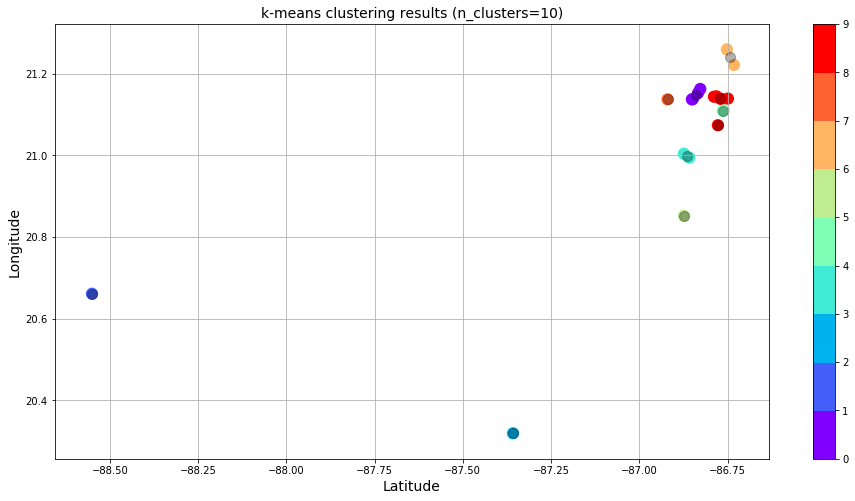

In [24]:
fig = plt.figure(figsize=(16,8))
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(clustered['Longitude'], clustered['Latitude'], c=clustered['Cluster'],
            cmap=cmap, norm=norm, s=150, edgecolor='none')
plt.colorbar(ticks=np.linspace(0,9,10))
centers = kmeans_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.3);
#plt.xlim(2.28, 2.375)
#plt.ylim(48.84, 48.89)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)
plt.title('k-means clustering results (n_clusters=10)', fontsize=14)
plt.grid()
plt.show()

HDBSCAN removes any noise (such as locations that are too far from the rest)

In [25]:
import hdbscan

In [26]:
rads = np.radians(X)
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='haversine')
predictions = clusterer.fit_predict(rads)

In [37]:
clustered = pd.concat([sample_df.reset_index(),
                       pd.DataFrame({'Cluster':predictions})],
                     axis = 1)
clustered.drop('index', axis = 1, inplace = True)

conditions = [
    clustered['Cluster'] == -1, 
    clustered['Cluster'] == 0,
    clustered['Cluster'] == 1,
    clustered['Cluster'] == 2,
    clustered['Cluster'] == 3,
    clustered['Cluster'] == 4,
    clustered['Cluster'] == 5,
    clustered['Cluster'] == 6,
    clustered['Cluster'] == 7,
    clustered['Cluster'] == 8 ]
choices = ['NA/Noise', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 
           'Friday','Saturday', 'Sunday', 'Monday', 'Tuesday' ]
clustered['Vacation Day'] = np.select(conditions, choices, default='black')
clustered.sort_values(by=['Cluster'])

,Attractions,Genres,Descriptions,City,Ratings,Reviews,Latitude,Longitude,Address,Cluster,Vacation Day
1,Tortugranja,Museums|Kid-friendly,Indoor-outdoor aquarium with turtles,Cancun,4.2,"3,508",21.2214,-86.7318,"Isla Mujeres, 77400 Quintana Roo, Mexico",-1,NA/Noise
2,Ik Kil,Outdoors|History|Kid-friendly,Cenote with swimming & hanging vines,Cancun,4.6,"1,297",20.6610,-88.5504,"Ik Kil, Yucatan, Mexico",-1,NA/Noise
15,Xel-Há Park,Outdoors|Beaches|History|Kid-friendly,Natural aquarium with many activities,Cancun,4.8,"24,714",20.3194,-87.3578,"Carretera Chetumal Puerto Juárez Km 240, local...",-1,NA/Noise
8,Playa Chacmool,Beaches|Kid-friendly,Sandy oceanfront spot with wavy waters,Cancun,4.6,249,21.1371,-86.9198,"Playa Chacmool, Cancún, Q.R., Mexico",-1,NA/Noise
19,Artesano Park,Kid-friendly,Park,Cancun,4.3,600,21.1626,-86.8271,"Artesano Park, MZA 26, Margaritas 26, 22, 7750...",0,Monday
7,Planetario De Cancún Ka´Yok´,Kid-friendly,Small planetarium & observatory,Cancun,4.3,92,21.1530,-86.8333,"Av. Palenque s/n, M05, Lt 1, 21, 77505 Cancún,...",0,Monday
16,Playa El Cocal,Beaches,Beach,Cancun,4.9,15,21.2594,-86.7518,"Playa El Cocal, Centro - Supmza. 001, Isla Muj...",1,Tuesday
10,Caracol Beach,Beaches,Beach,Cancun,4.4,37,21.1391,-86.7488,"Playa Caracol, Punta Cancun, Q.R., Mexico",1,Tuesday
12,Cancun Country Club,Kid-friendly,Golf and country club,Cancun,4.5,293,21.0040,-86.8736,"Km. 388, México 307, 46, 77580 Cancún, Q.R., M...",2,Wednesday
9,Playa Sol,Beaches,Sandy beach known for its sunsets,Cancun,4.7,"1,837",20.8520,-86.8734,"M1 R2, Javier Rojo Gomez, 77580 Puerto Morelos...",2,Wednesday


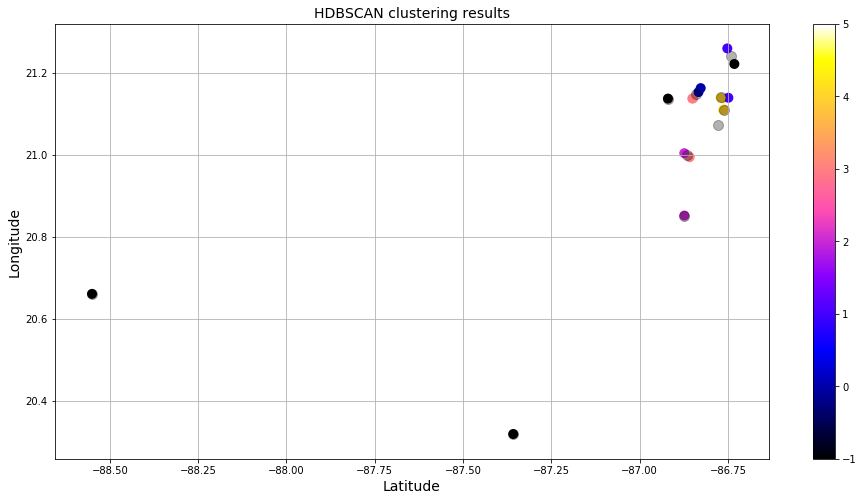

In [28]:
fig = plt.figure(figsize=(16,8))
cmap=plt.cm.gnuplot2
#norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(clustered['Longitude'], clustered['Latitude'], c=clustered['Cluster'],
            cmap=cmap, s=100, edgecolor='none')
plt.colorbar(ticks=[-1,0,1,2,3,4,5,6,7,8])
centers = kmeans_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.3);
#plt.xlim(2.28, 2.375)
#plt.ylim(48.84, 48.89)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)
plt.title('HDBSCAN clustering results', fontsize=14)
plt.grid()
plt.show()

Although HDBSCAN is a great density based spatial clustering algorithm, the cons to it is that some locations will not be located because they are deemed "noise." 

There may be some attractions that may be out of the way and not in normal common areas. These attractions may be ones that one would want to visit, so using hdbscan may not be the best ideal algorithm to use.

To tackle this problem, we should use spatial data clustering with DBSCAN


In [29]:
from sklearn.cluster import DBSCAN

In [30]:
cols = ['Latitude','Longitude']
coords = sample_df.as_matrix(columns = cols)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [31]:
kms_per_radian = 6371.0088
epsilon = 5/ kms_per_radian
db = DBSCAN(eps = epsilon, min_samples = 1, algorithm = 'ball_tree', metric = 'haversine').fit(np.radians(coords))

In [32]:
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [33]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [34]:
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 7


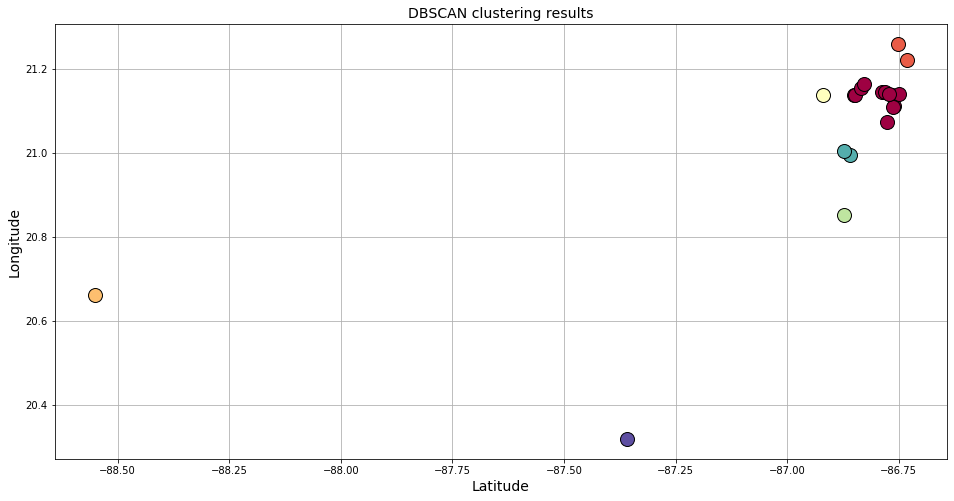

In [43]:
fig = plt.figure(figsize=(16,8))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)
plt.title('DBSCAN clustering results', fontsize=14)
plt.grid()
plt.show()

In [ ]:
# choices = ['NA/Noise', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 
#            'Friday','Saturday', 'Sunday', 'Monday', 'Tuesday' ]
# clustered['Vacation Day'] = np.select(conditions, choices, default='black')
# clustered.sort_values(by=['Cluster'])